# Introduction

One place where data analytics can play an important role in ecommerce is in deciding how to display search results. Imagine you are searching for a flight from Cape Town to Amsterdam. There are potentially hundreds of different flight options that could be returned. But you want to see ones that are most relevant to you nearer the top. And from the company's perspective, they want to show you flght options nearer to the top that you are most likely to want to book. In this sense, the your interests and that of the online retailer are aligned - they want to you show you things that you are most likely to book and you want to most easily find the things that you want. But how do companies decide what results to show near the top or to highlight? One common category of results are ones that are good value for money. In this notebook, I explore how we can think of value for money by analysis a data set of wines.

Consider this: you are a data scientist at a company that sells wine online. You are considering experimenting with a new feature - you will highlight the best value for money wine on the top of the search results page. Someone could search, for instance, "Cabernet Suavignon South Africa" and get back a bunch of potential results, like this:

In [20]:
wine.loc[(wine['variety']=='Cabernet Sauvignon') 
         & (wine['country']=='South Africa'), ['title', 'province', 'designation', 'points', 'price']].head(10)

,title,province,designation,points,price
125,Le Riche 2003 Cabernet Sauvignon Reserve Caber...,Stellenbosch,Cabernet Sauvignon Reserve,91,45.0
132,Delheim 2001 Grand Reserve Cabernet Sauvignon ...,Simonsberg-Stellenbosch,Grand Reserve,91,30.0
258,Hartenberg 2007 Cabernet Sauvignon (Stellenbosch),Stellenbosch,NaN,89,35.0
4659,Stark-Condé 2006 Cabernet Sauvignon (Stellenbo...,Stellenbosch,NaN,89,27.0
4989,Rietvallei Estate Wine 2007 Juanita Rosé Caber...,Robertson,Juanita Rosé,88,19.0
5573,Morgenhof 2009 Mint Haven Cabernet Sauvignon (...,Simonsberg-Stellenbosch,Mint Haven,90,24.0
6790,Le Riche 2003 Cabernet Sauvignon (Stellenbosch),Stellenbosch,NaN,89,25.0
6948,Rietvallei Estate Wine 2007 Cabernet Sauvignon...,Robertson,NaN,89,15.0
7697,Eventide Cellar 2005 Cabernet Sauvignon (Welli...,Wellington,NaN,86,15.0
10050,Thelema 2009 The Mint Cabernet Sauvignon (Stel...,Stellenbosch,The Mint,89,45.0


You might have some way of sorting by default (maybe by popularity or price) but at the top of the results you would highlight the best value for money wine. The question is how do you determine which wine that is?

I will be exploring 3 different potential ways of doing this, adding layers of sophistication in each subsequent method:
1. Rank wines from highest to lowest score within their respective price range. The best value for money wine could be the one with the highest rank out of the wines returned by the search.
2. Create value for money index (divide scaled points into log of price). The wine with the highest index could be the best value for money.
3. Regress price on available predictors and measure how far above the predicted price each wine is. The wine that is the most below its predicted price could be the best value for money.

This notebook proceeds in 3 parts - first, I am going to do some data wrangling in order to get the data into a form that will be easier to analyse later. Then I will explain and develop the 3 methods for working out which wines are the best value for money. Finally, I will discuss some potential issues and ways to improve on my methods before concluding.

In [136]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

# Change working directory
if 'dir_changed' in locals():
    pass
else:
    os.chdir(os.path.abspath(os.path.join(os.path.dirname(os.path.realpath(sys.argv[1])), os.pardir)))
    dir_changed = False

# Append location of customer modules to path and import modules
sys.path.append('src/custom-modules')
from model_diagnostics import regression_model_report, regression_model_cv_report, plot_actual_vs_predicted
from dataframe_imputer import DataFrameImputer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import metrics
# from xgboost.sklearn import XGBClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.neighbors import KNeighborsRegressor


# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
wine = pd.read_csv('data/raw/winemag-data-130k-v2.csv', index_col = 0)

# Wrangling

### Extracting date from the title

It would be interesting to look at the year of the wine. While this isn't included as a column in the dataset, we can extract is from the `title` using regex. We will search the titles and find numbers that match years in the 20th and 21st centuries.

In [23]:
# regex to extract date (matching wines from 20th and 21st centuries)
wine['year'] = wine['title'].apply(lambda x: re.search(r'(19|20)[0-9]{2}', x))  # _sre.SRE_Match object returned
year_matched = pd.notnull(wine['year'])  # Find where there is a match (no match signified by `NaN`)
wine.loc[year_matched, 'year'] = wine.loc[year_matched, 'year'].apply(lambda x: x.group(0))  # Extract year where there is a match
# wine = wine[~wine['year'].isnull()]  # Drop columns where `year` is null (no match)
wine['year'] = wine['year'].astype(int, errors='ignore')
# wine = wine.dropna(axis = 0, how = 'any') 

### Duplicates

The dataset contains some duplicates. We can go ahead and drop duplicated rows where every column is duplicated. I'll keep the first occurance.

In [24]:
print('Duplicated rows:')
wine.duplicated().value_counts()
wine = wine.drop_duplicates(keep='first')

Duplicated rows:


False    119988
True       9983
dtype: int64

We can see that even though we've dropped rows where *every* column is diplicated, there are cases where the `title` is duplicated but there may be different scores. Which one do we keep? It appears that the duplicates arise where a wine is reviewed more than once. For example, `Ascension Cellars 2015 Silver White (Paso Robles)` appears twice, but the reviews were published in [2016](https://www.winemag.com/buying-guide/bianchi-2012-signature-selection-cabernet-sauvignon-paso-robles/) and [2017](https://www.winemag.com/buying-guide/bianchi-2012-signature-selection-cabernet-sauvignon-paso-robles-253492/), respectively. You can't see that from the data, since publication date isn't included. But I discovered this by going to the [WineEnthusiast](https://www.winemag.com/) website, from which this data were scraped, and searching for the offending reviews.

Since publication date isn't included in the data, we can't distinguish between reviews and there's no systematic way to decide which to keep. I'll keep the first occurance as it appears in the dataset. This solves the duplicating problem but it's worth noting that bias could be introduced here, as we're only keeping one review and there may be some information about wines with multiple reviews that we're missing. However, dropping both reviews where the `title` is duplicated could also introduce bias, since we'd only be looking at the subset of wines that have only one review. A better solution would be to include publication date and either include both reviews or systematically include one (the first or last publication for instance).

In [25]:
wine[wine.duplicated(subset='title', keep=False)].sort_values('title').head()
wine = wine.drop_duplicates(subset='title', keep='first')
print('Duplicated rows:')
wine.duplicated('title').value_counts()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
55163,Spain,Spiced apple and toast aromas are clean and di...,Brut,87,16.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,1+1=3 NV Brut Sparkling (Cava),Sparkling Blend,1+1=3,None
93375,Spain,Dusty notes of citrus fruits are mild but frie...,Brut,87,16.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,1+1=3 NV Brut Sparkling (Cava),Sparkling Blend,1+1=3,None
115461,France,"With zero grams of residual sugar, this is win...",Dosage Zéro Brut Nature,90,49.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,A.R. Lenoble NV Dosage Zéro Brut Nature (Cha...,Champagne Blend,A.R. Lenoble,None
36820,France,"Bone dry and crisp, this is also has fruitines...",Dosage Zéro Brut Nature,89,49.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,A.R. Lenoble NV Dosage Zéro Brut Nature (Cha...,Champagne Blend,A.R. Lenoble,None
38053,France,This tight crisp wine delivers citrus and slic...,Dosage Zéro Brut Nature,90,49.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,A.R. Lenoble NV Dosage Zéro Brut Nature (Cha...,Champagne Blend,A.R. Lenoble,None


Duplicated rows:


False    118840
dtype: int64

### Log-normalise price

Wine doesn't look like a nicely-behaved normal distribution. It has an extremely long tail to the right.

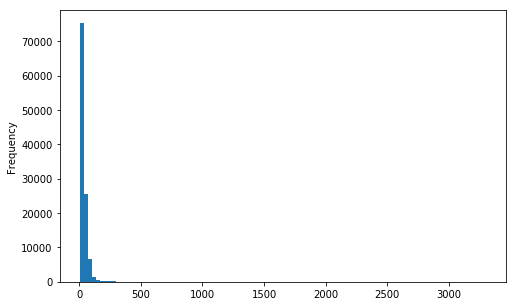

In [26]:
wine['price'].plot.hist(bins=100, figsize=(8, 5));

If we log price, we can now see a much more nicely-behaved price distribution. However, there are still some large outliers.

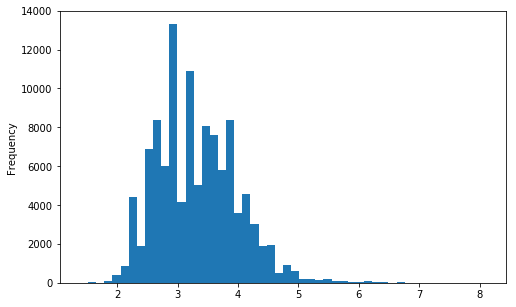

In [27]:
wine['log_price'] = np.log(wine['price'])
wine['log_price'].plot.hist(bins=50, figsize = (8, 5));

### Deal with outliers

We can see that there is a very long tail of prices. While there are more scientific ways to do this, it we just cut out any wines that are greater than 6 log-dollars, we get a much ore balanced picture. 

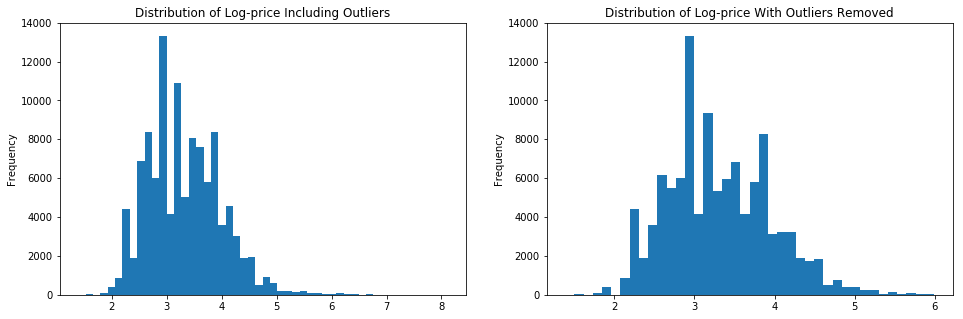

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
wine['log_price'].plot.hist(bins=50, ax=ax1)
ax1.set_title('Distribution of Log-price Including Outliers')
wine.loc[wine['log_price']<=6, 'log_price'].plot.hist(bins=40, ax=ax2)
ax2.set_title('Distribution of Log-price With Outliers Removed')
plt.show();

To keep things simple, I'm going to go ahead and remove the outliers. We can see that the mean and median are quite close (3.31 vs 3.22) and a balanced boxplot (even though there are still quite a few values larger than the 75th percentile) 

count    110410.000000
mean          3.311912
std           0.647999
min           1.386294
25%           2.833213
50%           3.218876
75%           3.737670
max           5.991465
Name: log_price, dtype: float64

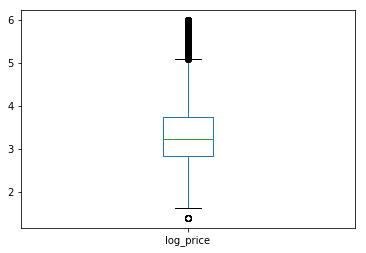

In [29]:
wine = wine.loc[wine['log_price']<=6]
wine['log_price'].describe();
wine['log_price'].plot.box()

# Value for money wines

Value for money is difficult to quantify but essentially it's a comparison of between 'value' and 'price'. Value is also an iffy concept and is very subjective. In this case, we have `points`, which is also subjective but since these are professional reviewers, it makes sense to think that they would at least be a good overall proxy for value. This seems to be supported by the observation that score tends to increase with the `price`, as illustrated in the boxplots below. We can see that there is a lot of overlap but the median score increases consistently with the log-price category.

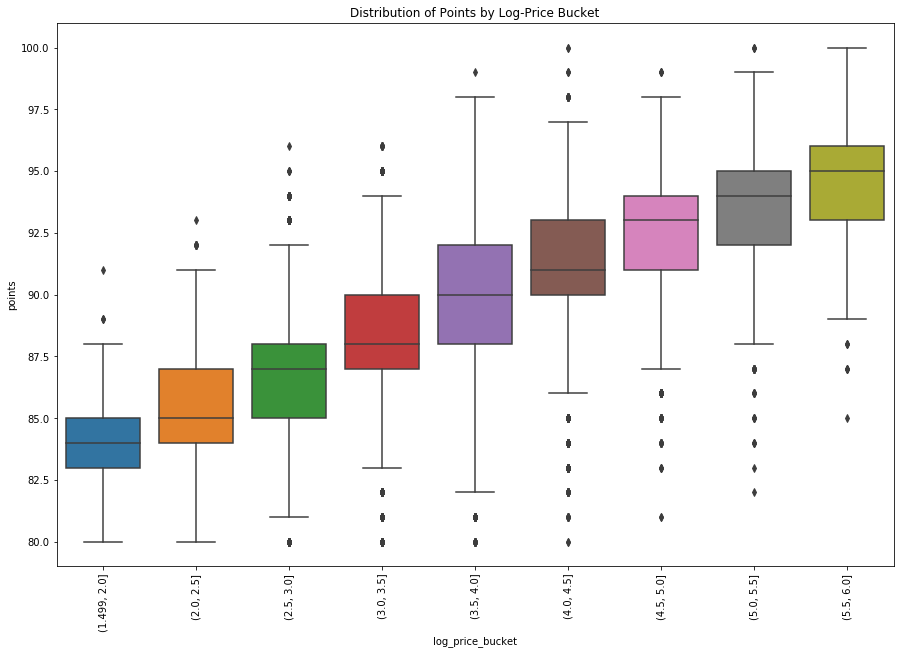

In [30]:
wine['log_price_bucket'] = pd.cut(wine['log_price'], np.arange(1.5, 6.5, 0.5), include_lowest=True)
fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['points'], x=wine['log_price_bucket'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Points by Log-Price Bucket')
plt.show();

## Relative score within price category

A very simple way of thinking about value for money could be to group the wines into price buckets (as in the boxplots above) and compare the wine's score to the median for the price category that it's in. If the score is greater than the median then it's good value for money and if it's below then it's not. Taken a step further, we can rank the wine from highest score to lowest within each price bucket. This gives us a way to compare wine's value for money even when they might lie in different buckets - a wine that ranks 3 in one price could be deemed to be better value for money than one that ranks 5 in a different bucket. Let's work out the medians for each log price cateogry, where the log of price is bucketed in 0.5 increments. 

What we can see is that a each category generally only has a 1 or 2 point difference from its neighbours. However, it we compare the (1.499, 2.0] category (3.5, 4.0] we can see a 5-point difference. And there's another 3 points difference between (3.5, 4.0] abd (5.5, 6.0] (highest category). 

In [31]:
wine.groupby('log_price_bucket')['points'].median()

log_price_bucket
(1.499, 2.0]    84
(2.0, 2.5]      85
(2.5, 3.0]      87
(3.0, 3.5]      88
(3.5, 4.0]      90
(4.0, 4.5]      91
(4.5, 5.0]      93
(5.0, 5.5]      94
(5.5, 6.0]      95
Name: points, dtype: int64

The incremental difference between neighbouring price categories might not seem like much but remember that the points only range from 80 to 100 some a difference of 1 points is actaully a difference of 1/20 = 5%. If we scale the scores so that they are expressed as a percentage between 0 and 1, we can see that the median scores' difference between category groups is relatively quite large (even though the differences are between 1 and 2 absolute points). That the absolute differences aren't very big reflects the reality that these are all excellent wines (since they all scored above 80) so we really are talking about eeking out the most value out of wines that are probably already good value compared to the general population of wines.

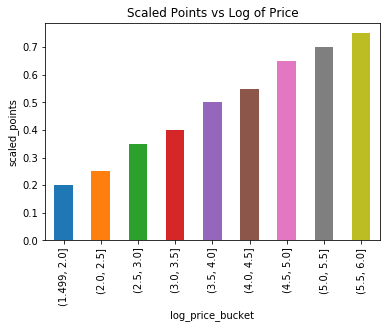

In [32]:
def scale(series):
    return (series - series.min()) / (series.max() - series.min())
wine['scaled_points'] = scale(wine['points'])

wine.groupby('log_price_bucket')['scaled_points'].median().plot.bar()
plt.ylabel('scaled_points')
plt.title('Scaled Points vs Log of Price')
plt.plot();

Let's go ahead and implement this method and see how it sorts our search result from above.

In [33]:
# Rank the wines by `points` within `log_price_bucket`s
wine['rank_group_score'] = wine.groupby('log_price_bucket')['points'].rank(ascending=0)

wine.loc[(wine['variety']=='Cabernet Sauvignon') 
         & (wine['country']=='South Africa'), 
         ['title', 'province', 'designation', 'points', 'price', 'log_price_bucket', 'rank_group_score']].sort_values('rank_group_score').head(10)

,title,province,designation,points,price,log_price_bucket,rank_group_score
12255,Simonsig 1998 Cabernet Sauvignon (Stellenbosch),Stellenbosch,NaN,93,15.0,"(2.5, 3.0]",93.5
99964,Excelsior 2011 Cabernet Sauvignon (Robertson),Robertson,NaN,89,10.0,"(2.0, 2.5]",385.0
99957,Riebeek Cellars 2011 Cabernet Sauvignon (Swart...,Swartland,NaN,89,10.0,"(2.0, 2.5]",385.0
107351,David Frost 2014 Cabernet Sauvignon (Western C...,Western Cape,NaN,88,12.0,"(2.0, 2.5]",972.0
62799,Stark-Condé 2011 Unfined and Unfiltered Cabern...,Stellenbosch,Unfined and Unfiltered,92,27.0,"(3.0, 3.5]",1846.0
65229,Robertson Winery 2011 Cabernet Sauvignon (Robe...,Robertson,NaN,87,10.0,"(2.0, 2.5]",2254.0
39807,Fleur Du Cap 2009 Bergkelder Selection Caberne...,Western Cape,Bergkelder Selection,87,12.0,"(2.0, 2.5]",2254.0
62468,Riebeek Cellars 2014 Collection Cabernet Sauvi...,Swartland,Collection,87,10.0,"(2.0, 2.5]",2254.0
36261,Mulderbosch 2008 Rosé Cabernet Sauvignon (Stel...,Stellenbosch,Rosé,87,12.0,"(2.0, 2.5]",2254.0
77692,Robertson Winery 2002 Cabernet Sauvignon (Robe...,Robertson,NaN,87,10.0,"(2.0, 2.5]",2254.0


In [34]:
wine.loc[(wine['variety']=='Cabernet Sauvignon') 
         & (wine['country']=='South Africa'), 
         ['title', 'province', 'designation', 'points', 'price', 'log_price_bucket', 'rank_group_score']].sort_values('points', ascending=0).head(10)

,title,province,designation,points,price,log_price_bucket,rank_group_score
90362,Glenelly 2009 Lady May Cabernet Sauvignon (Ste...,Stellenbosch,Lady May,93,50.0,"(3.5, 4.0]",2363.5
12255,Simonsig 1998 Cabernet Sauvignon (Stellenbosch),Stellenbosch,NaN,93,15.0,"(2.5, 3.0]",93.5
62783,Glenelly 2011 Lady May Cabernet Sauvignon (Ste...,Stellenbosch,Lady May,93,50.0,"(3.5, 4.0]",2363.5
126517,Glenelly 2008 Lady May Cabernet Sauvignon (Sim...,Simonsberg-Stellenbosch,Lady May,92,50.0,"(3.5, 4.0]",4956.0
105031,Anthonij Rupert 2007 Cabernet Sauvignon (Coast...,Coastal Region,NaN,92,65.0,"(4.0, 4.5]",5126.0
66749,Rustenberg 2005 Peter Barlow Cabernet Sauvigno...,Stellenbosch,Peter Barlow,92,49.0,"(3.5, 4.0]",4956.0
62799,Stark-Condé 2011 Unfined and Unfiltered Cabern...,Stellenbosch,Unfined and Unfiltered,92,27.0,"(3.0, 3.5]",1846.0
25447,Stark-Condé 2005 Twin Peak Vineyards Unfined a...,Jonkershoek Valley,Twin Peak Vineyards Unfined and Unfiltered,91,42.0,"(3.5, 4.0]",8274.0
126386,Cederberg 2008 Cabernet Sauvignon (Cederberg),Cederberg,NaN,91,40.0,"(3.5, 4.0]",8274.0
121328,Kanonkop 2004 Estate Wine Cabernet Sauvignon (...,Stellenbosch,Estate Wine,91,35.0,"(3.5, 4.0]",8274.0


That's not back. We can see that the wine at the top of the list scores 93 but is only \$15. In this case, we can see that it was also one of the 3 wines with the highest score. However, it is much cheaper than the other 2, which cost $50 each. Let's see if we can improve on this.

## Ratio of standardised score to log price

The above method will work for figuring out if a wine is comparitively good value for its price category. However, there are 3 things that could perhaps be improved:
1. It is somewhat clunky in that we have to first separate wines by category before ranking them. You have to know which category each wine is in before you can make a comparison.
2. We are using somewhat arbitrary log-price buckets to group the wine.
3. It doesn't provide a way to quantitatively compare value for money across categories. 

How does a wine that ranks 100 in bucket (3.5, 4.0] compare to one that ranks 50 in bucket (3, 3.5]? The second wine has a better rank within its price bucketbut is it really a better value for money wine? It would be nice to have one number that we could use to compare them. Now we can't just divide `points` by `price` because the scales of each variable don't make sense. We can see this below, where I have plotted `points_per_dollar` within price cateogry buckets. The naive index says that value for money decreases as the price of the wine increases. This isn't the type of behaviour that we'd want from an index that measures value for money.

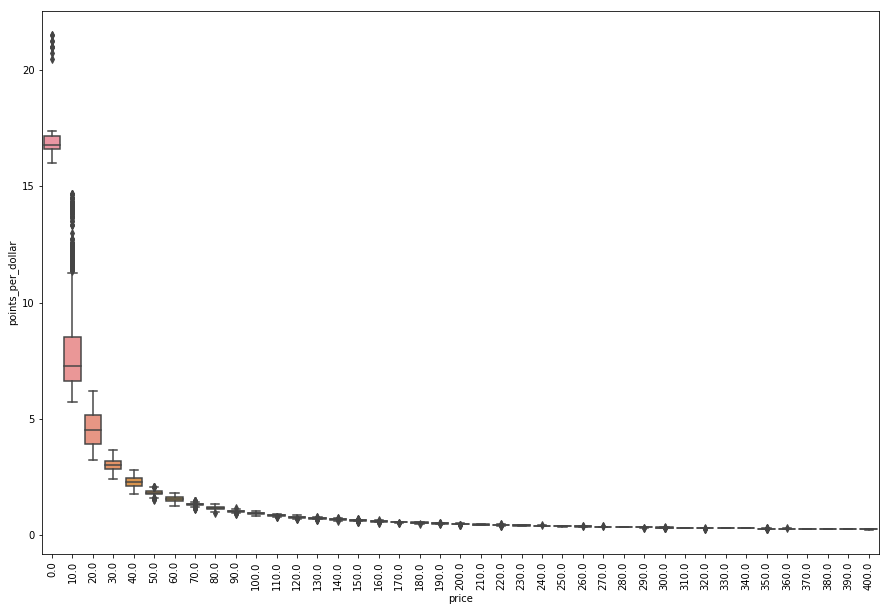

In [35]:
wine['points_per_dollar'] = wine['points']/wine['price'] 

wine['price_cat'] = pd.cut(wine['price'], range(0, wine['price'].max().astype(int), 5), include_lowest=True)
fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['points_per_dollar'], x=round(wine['price'], -1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

The reason for this is twofold. For one, the points aren't on a continuous scale. They range between 80 and 100. To illustrate why this is a problem, imagine if you have a \$20 wine and you want to compare its value for money to a bottle that has a score of 85 and price of $10, giving it a score:price ratio of 8.5. Since your bottle is double the price, for it to have a score:price ratio of 8.5, it would need to have double the points. But that would mean that it would need a score of 170, which is impossible. So the points need to be scaled so that they show relative differences. Second, As we have already seen above, the distribution of price is skewed with very large prices. It is approximately log-normally distributed - large prices are very large. 

This motivates for scaling points so that differences between scores are relative (we did this above by dividing the difference between the score and the minimum score and dividing this by the range - the difference between the minimum and maximum scores) and using log-price in the denominator.

The graph below shows how `scaled_points_per_log_dollar` (the `scaled points` from above divided by `log_price`) is disctibuted over log price buckets of 0.5 log-dollars. The values are much more stable around 0.1 and 0.4. An interesting outcome of this index is that wines that are more expensive tend to have a tighter distribution around the median. If we take this index to really measure value for money (more on this later), this could be interpreted as meaning that more expensive wines are more consistently closer to average value for money. While cheaper wines have the potential to be worse value for money, they can also be better value than more expensive wines. This makes intuitive sense. More expensive wines are less likely to be of bad quality. However, you will also be hard-pressed to find bargains.

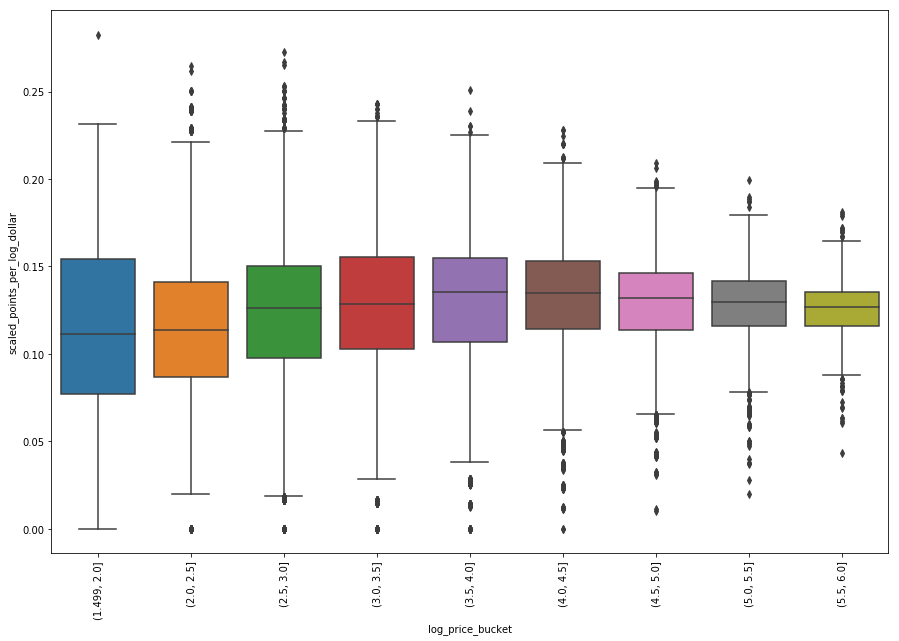

In [37]:
wine['scaled_points_per_log_dollar'] = wine['scaled_points']/wine['log_price'] 

fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['scaled_points_per_log_dollar'], x=wine['log_price_bucket'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

In [ ]:
wine.groupby('log_price_cat')['scaled_points_per_log_dollar'].agg(['median', 'max', 'min'])

What's nice about this index is that the value itself gives us a sense of how much value for money the wine is, nomatter which price category the wine is in. 

In [49]:
searched = wine.loc[(wine['variety']=='Cabernet Sauvignon') 
         & (wine['country']=='South Africa'), 
         ['title', 'province', 'designation', 'points', 'price', 'log_price_bucket', 
          'rank_group_score', 'scaled_points_per_log_dollar']]

searched.sort_values('scaled_points_per_log_dollar', ascending=False).head(10)

,title,province,designation,points,price,log_price_bucket,rank_group_score,scaled_points_per_log_dollar
12255,Simonsig 1998 Cabernet Sauvignon (Stellenbosch),Stellenbosch,NaN,93,15.0,"(2.5, 3.0]",93.5,0.240025
99964,Excelsior 2011 Cabernet Sauvignon (Robertson),Robertson,NaN,89,10.0,"(2.0, 2.5]",385.0,0.195433
99957,Riebeek Cellars 2011 Cabernet Sauvignon (Swart...,Swartland,NaN,89,10.0,"(2.0, 2.5]",385.0,0.195433
62799,Stark-Condé 2011 Unfined and Unfiltered Cabern...,Stellenbosch,Unfined and Unfiltered,92,27.0,"(3.0, 3.5]",1846.0,0.182048
113684,Glen Carlou 2006 Cabernet Sauvignon (Paarl),Paarl,NaN,90,16.0,"(2.5, 3.0]",3155.0,0.180337
68179,Rudera 2008 Cabernet Sauvignon (South Africa),South Africa,NaN,91,22.0,"(3.0, 3.5]",4119.5,0.177933
59890,Beau Joubert 2004 Cabernet Sauvignon (Stellenb...,Stellenbosch,NaN,90,17.0,"(2.5, 3.0]",3155.0,0.176478
77502,Glenelly 2008 The Glass Collection Cabernet Sa...,Western Cape,The Glass Collection,90,18.0,"(2.5, 3.0]",3155.0,0.172988
6948,Rietvallei Estate Wine 2007 Cabernet Sauvignon...,Robertson,NaN,89,15.0,"(2.5, 3.0]",6096.5,0.166171
90362,Glenelly 2009 Lady May Cabernet Sauvignon (Ste...,Stellenbosch,Lady May,93,50.0,"(3.5, 4.0]",2363.5,0.166154


We can also see that our new index is quite nicely distributed around the mean value for money, while the metric above, which uses rank, does not have this characteristic.

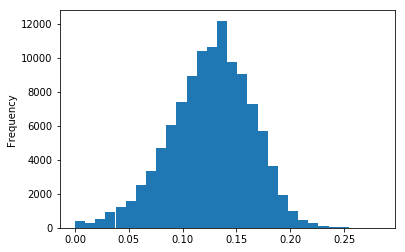

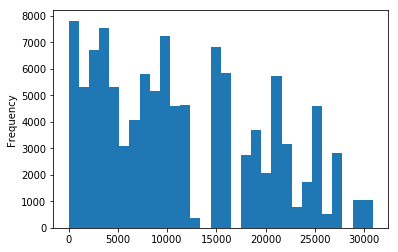

In [54]:
wine['scaled_points_per_log_dollar'].plot.hist(bins=30)
plt.show();
wine['rank_group_score'].plot.hist(bins=30)
plt.show();

While this metric seems to work for our purposes, it is also quite naive because it only looks at the trade-off between score and price. In reality, value for money is more nuanced. The final approach, which I put forward in the following section, attempts a remedy.

## Regression model to predict price and then flag wines that have prices lower than expected

The above method for determining value for money, by working out an index that compares score to price, shows some improvements over the simpler method of comparing the score of a wine to the median score of its price bucket. However, both methods fail to capture certain nuances. What if score isn't the sole factor that people care about when purchasing a wine? What if there are other things that determine what price someone is willing to pay for a wine? For example, wines from a particular year and place, or of a particular variety, might tend to be priced differently. If this is the case then simply looking at the score might cause us to think that a wine is overpriced when in fact it is not. 

One method that we could use is to estimate the price of the wine and compare that to the actual price. If the actual price is lower than what we predict then we can say that it is good value for money. By comparing how far our prediction is from the actual value (working out the `residual`), we can attempt to quantify how good value for money a wine is.

First, Let's split the data into train and test sets.

In [85]:
train, test = np.split(wine.sample(frac=1), [int(0.5*len(wine))])

First, let's get a baseline by just price on score.

In [86]:
feature_cols = ['scaled_points']  # Only using points

y_train = train['log_price']  
X_train = train[feature_cols]

linreg = LinearRegression()
regression_model_cv_report(X_train, y_train, linreg, n_folds=10)  # This is my own function that runs some model diagnostics using k-fold cross-validation

Average Root Mean Squared Error: 0.5121, which is 11.12% of the range of y
Average R2: 0.3789
Average adjusted R2: 0.3788


From the above output, we can see that the cross-validated RMSE of our model is relatively high at about 0.5, representing about 11% of the range of the wine's log-price. The adjusted R2 of 0.38 means that the score explains 38% of the variance in price. The graph below compares actual and predicted values. The fitted line in blue. A model that predicted price perfectly would have predictions that lie on the red line. As we can see, our model tends to over-predict lower-priced wines and under-predict higher-priced wines.

Let's try do better using the data that we have.

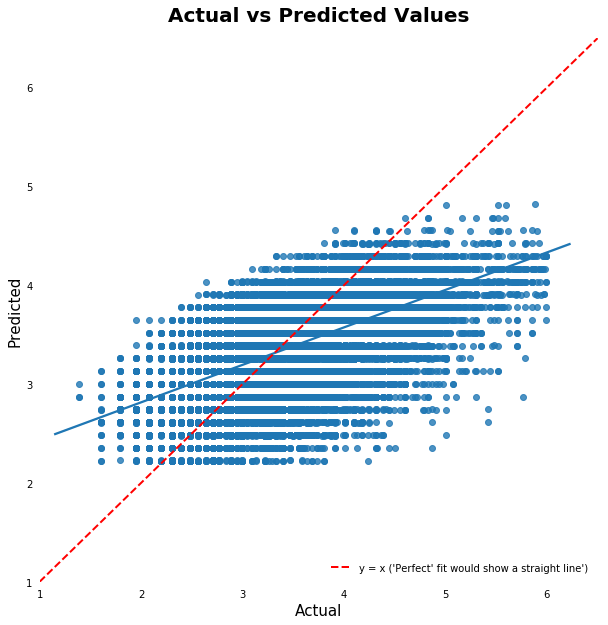

In [89]:
y_pred = cross_val_predict(linreg, X_train, y_train, cv=10)
plot_actual_vs_predicted(y_train, y_pred, xlim=(1, 6.5), ylim=(1, 6.5), legend_loc='lower right')

Plotting other columns against price, we can see that country, province, region, year, and variety could be used to differentiate between them. This doesn't say anything about a _causal_ relationship but it suggests that we could possible add some other features in the model to better predict price.

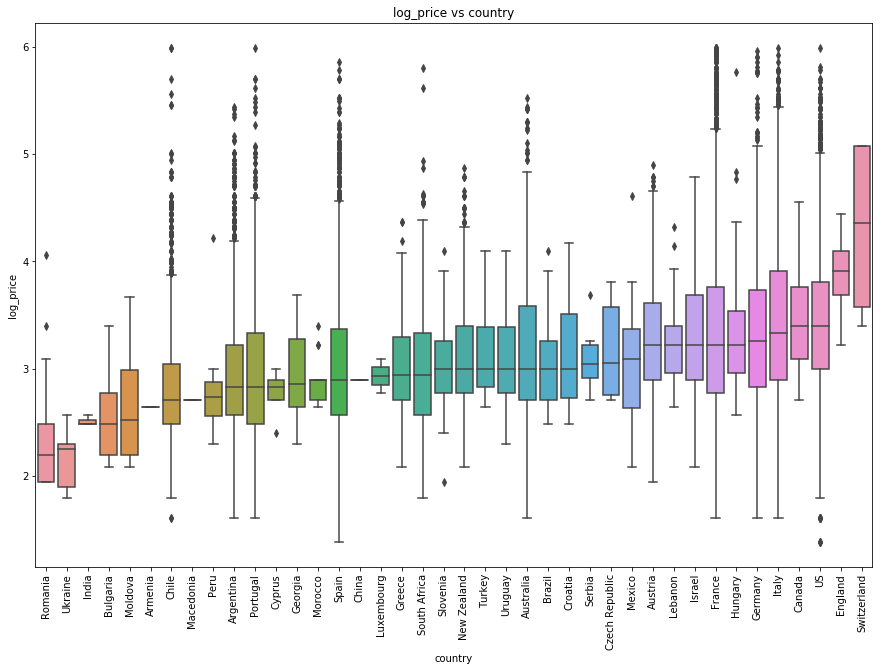

In [59]:
col = 'country'
fig, ax = plt.subplots(figsize = (15, 10))
medians = train.groupby(col)['log_price'].median().sort_values(ascending=True)
sns.boxplot(y=train['log_price'], x=train[col], order=medians.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('log_price vs {0}'.format(col))
plt.show();

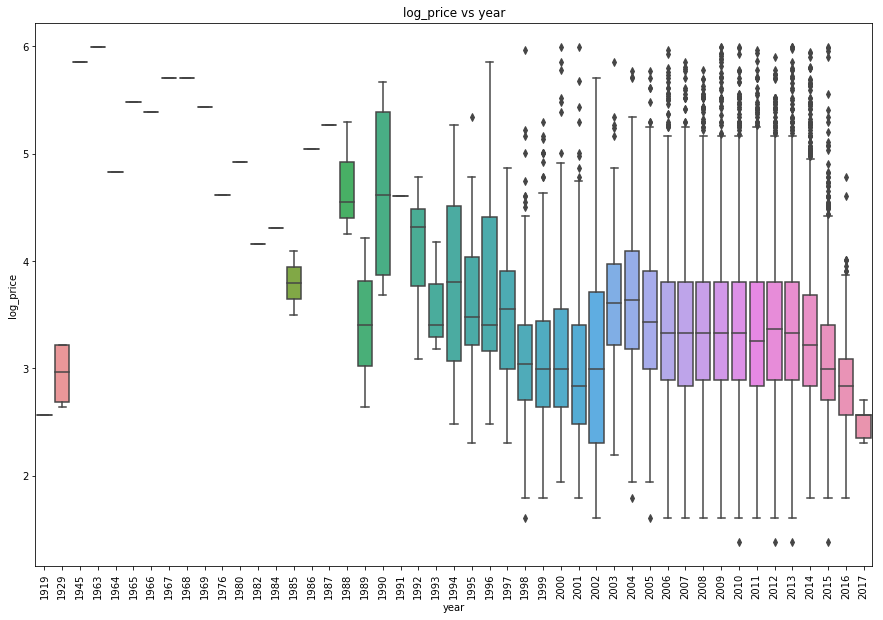

In [60]:
wine_w_year = train.loc[train['year'].notnull(), ['year', 'log_price']]
col = 'year'
fig, ax = plt.subplots(figsize = (15, 10))
rank = sorted(list(wine_w_year['year'].unique()))
sns.boxplot(y=wine_w_year['log_price'], x=wine_w_year[col], order=rank)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('log_price vs {0}'.format(col))
plt.show();

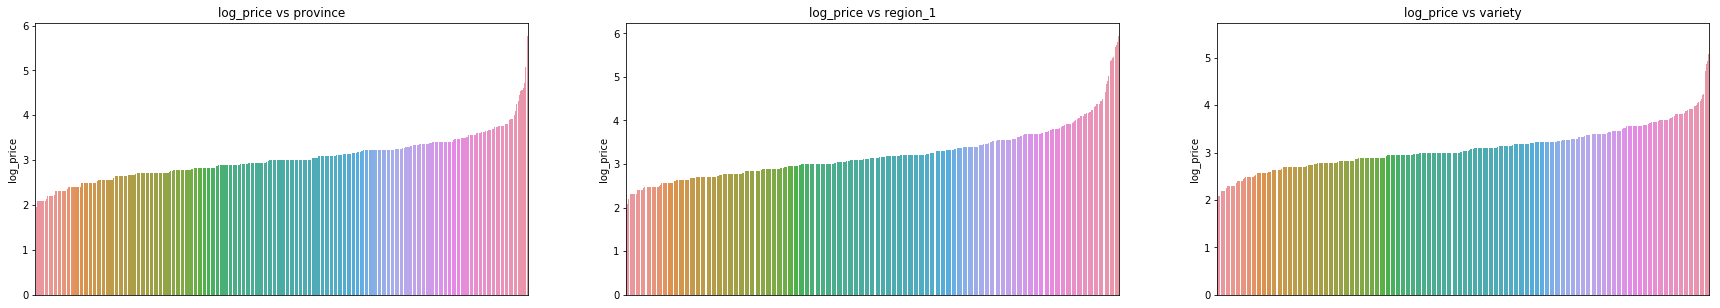

In [99]:
cols_to_plot = ['province', 'region_1', 'variety']
fig, axes = plt.subplots(1, 3, figsize = (30, 5))
for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    medians = train.groupby(col)['log_price'].median().sort_values(ascending=True)
    sns.barplot(y=medians, x=medians.index, ax=ax)
    ax.set_title('log_price vs {0}'.format(col))
    ax.get_xaxis().set_visible(False)
plt.show();

We can't just throw all of these new features into the model because they not continuous. Year could be seen as continuos but from above, there isn't any obvious linear relationship if we treat it as such. One can deal with such variables by constructing dummy variables. However, there are too many categories here compared to observations to do this. There are several different methods that one can employ to deal witht this. One way would be to use a clutering algorithm to group the data into a smaller number of relevant combinations of features. I have chosen to simply recode them in quinties. First, we find the median price for each category. Then we can assign the category to a quintiles based on where that median sits on the distribution compared to the medians for all the other categories. Then we can create dummy variables based on these quintiles.

In [100]:
cols_to_recode = ['country', 'year', 'province', 'region_1', 'variety']
medians = {}
for col in cols_to_recode:
    col_medians = train.groupby(col)['log_price'].median().sort_values(ascending=True).reset_index()  # Get median price, by group
    col_medians['quintiles'] = pd.qcut(x=col_medians['log_price'], q=5, labels=[1, 2, 3, 4, 5])  # Get quintile for each median value
    col_medians.index = col_medians[col]
    col_medians = col_medians.drop(col, axis=1)
    train[col + '_quintile'] = train[col].map(col_medians['quintiles'])  # Create new column in `train` which contains the quintile that that observation falls into
    medians[col] = col_medians

In [101]:
feature_cols = ['scaled_points', 'country_quintile', 'year_quintile', 'province_quintile', 'region_1_quintile', 'variety_quintile']

y_train = train['log_price']
X_train = train[feature_cols]
X_train = pd.get_dummies(X_train).reset_index()  # Create dummies

linreg = LinearRegression()
regression_model_cv_report(X_train, y_train, linreg, 10)

Average Root Mean Squared Error: 0.4181, which is 9.08% of the range of y
Average R2: 0.5861
Average adjusted R2: 0.5841


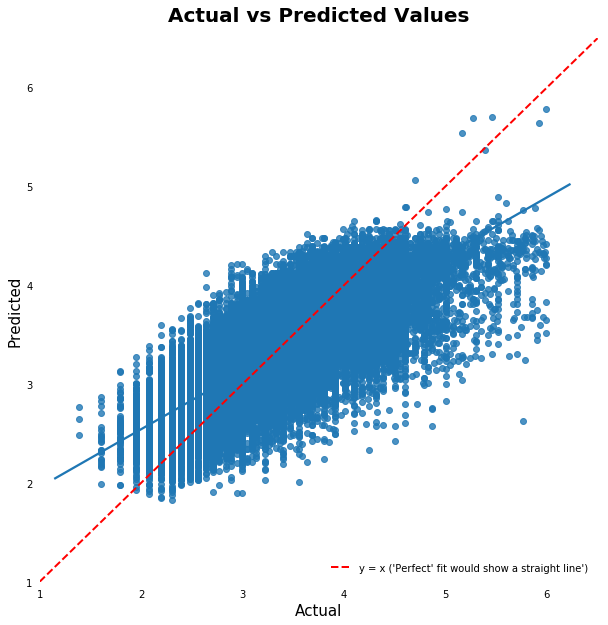

In [102]:
y_pred = cross_val_predict(linreg, X_train, y_train, cv=10)
plot_actual_vs_predicted(y_train, y_pred, xlim=(1, 6.5), ylim=(1, 6.5), legend_loc='lower right')

We can see that this does produce an improvement, with an RMSE that is about 9% of the range of log-price (as oppsed to 11%) and an adjusted R2 of 20 percentage points higher (from 0.58 from 0.38). While the model still under-predicts lower-value wines and over-predicts higher-value wines, the predicted values are closer to the actual value and the slope of best-fit line through those points is closer to the 'perfect-fit' y=x line than before.

We could keep going and try different types of models and different specifications. I will touch on this in the next section 'Problems and Improvements'. For now, let's go with this model and see how it performs by using it to predict values in the test-set. Doing so, we can see that the final R2 is 0.56 and RMSE is 0.42. These values are, predictably, worse than the cross-valided validation metrics from the train-set but not by too much, which suggests that over-fitting isn't a problem here.

In [65]:
cols_to_recode = ['country', 'year', 'province', 'region_1', 'variety']
for col in cols_to_recode:
    test[col + '_quintile'] = test[col].map(medians[col]['quintiles'])

y_test = test['log_price']
X_test = test[feature_cols]
X_test = X_test.fillna(X_test.median())
X_test = pd.get_dummies(X_test).reset_index()

results = regression_model_report(X_train, y_train, X_test, y_test, linreg) 

Average Root Mean Squared Error: 0.4283, which is 9.30% of the range of y
Average R2: 0.5641
Average adjusted R2: 0.5639


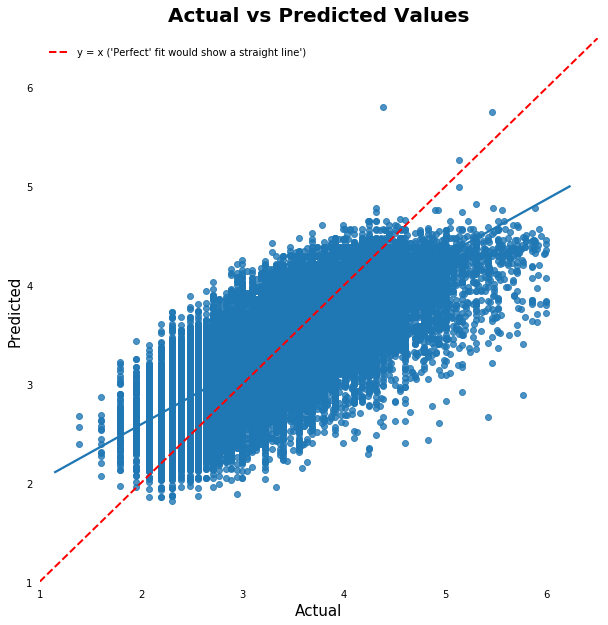

In [103]:
linreg.fit(X_train, y_train)
y_test_pred = linreg.predict(X_test)
plot_actual_vs_predicted(y_test, y_test_pred, xlim=(1, 6.5), ylim=(1, 6.5));

To get our final results, we can learn the model on the full set of data

In [135]:
wine[cols_to_recode].median()
# x[x.isnull()]

Series([], dtype: float64)

In [139]:
cols_to_recode = ['country', 'year', 'province', 'region_1', 'variety']
wine[cols_to_recode] = DataFrameImputer().fit_transform(wine[cols_to_recode])

medians = {}
for col in cols_to_recode:
    col_medians = wine.groupby(col)['log_price'].median().sort_values(ascending=True).reset_index()
    col_medians['quintiles'] = pd.qcut(x=col_medians['log_price'], q=5, labels=[1, 2, 3, 4, 5])
    col_medians.index = col_medians[col]
    col_medians = col_medians.drop(col, axis=1)
    wine[col + '_quintile'] = wine[col].map(col_medians['quintiles'])

y = wine['log_price']
X = wine[feature_cols]
X = pd.get_dummies(X).reset_index()

linreg.fit(X, y)
y_pred = linreg.predict(X)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [140]:
wine['predicted_price'] = np.exp(y_pred)
wine['residual_pct'] = (np.exp(y) - np.exp(y_pred))/np.exp(y_pred)

# searched = wine.loc[(wine['variety']=='Cabernet Sauvignon') 
#          & (wine['country']=='South Africa'), 
#          ['title', 'province', 'region_1', 'variety', 'designation', 'year', 'points', 'price', 'log_price_bucket', 
#           'rank_group_score', 'scaled_points_per_log_dollar', 'log_price', 'predicted_log_price', 'residual_pct']]

searched = wine.loc[(wine['country']=='South Africa'), 
         ['title', 'province', 'region_1', 'variety', 'designation', 'year', 'points', 'price', 'predicted_price', 'log_price_bucket', 
          'rank_group_score', 'scaled_points_per_log_dollar', 'log_price', 'residual_pct']]

searched.sort_values('residual_pct', ascending=False).head(10)

,title,province,region_1,variety,designation,year,points,price,predicted_price,log_price_bucket,rank_group_score,scaled_points_per_log_dollar,log_price,residual_pct
8114,Kanonkop 2013 Estate Wine Black Label Pinotage...,Simonsberg-Stellenbosch,Napa Valley,Pinotage,Estate Wine Black Label,2013,93,275.0,37.903011,"(5.5, 6.0]",246.0,0.115725,5.616771,6.255360
9912,De Toren 2014 Book 17 XVII Red (Stellenbosch),Stellenbosch,Napa Valley,Bordeaux-style Red Blend,Book 17 XVII,2014,95,330.0,46.361047,"(5.5, 6.0]",122.5,0.129331,5.799093,6.118045
123839,Alheit 2014 Radio Lazarus Single Vineyard Chen...,Western Cape,Napa Valley,Chenin Blanc,Radio Lazarus Single Vineyard,2014,91,100.0,20.980936,"(4.5, 5.0]",2128.0,0.119431,4.605170,3.766232
67998,Hartenberg 2005 Gravel Hill Shiraz (Stellenbosch),Stellenbosch,Napa Valley,Shiraz,Gravel Hill,2005,89,139.0,35.109420,"(4.5, 5.0]",2648.0,0.091195,4.934474,2.959051
24081,Alheit 2014 Magnetic North Mountain Makstok Ch...,Olifants River,Napa Valley,Chenin Blanc,Magnetic North Mountain Makstok,2014,90,100.0,25.453217,"(4.5, 5.0]",2431.5,0.108574,4.605170,2.928777
103992,Abraham Perold 1998 Shiraz (Paarl),Paarl,Napa Valley,Shiraz,NaN,1998,94,155.0,42.637804,"(5.0, 5.5]",371.0,0.138795,5.043425,2.635272
111532,KWV 2011 The Mentors Chardonnay (Elgin),Elgin,Napa Valley,Chardonnay,The Mentors,2011,85,72.0,21.358448,"(4.0, 4.5]",12547.5,0.058457,4.276666,2.371031
101153,DeMorgenzon 2013 The Divas Chenin Blanc (Stell...,Stellenbosch,Napa Valley,Chenin Blanc,The Divas,2013,92,105.0,32.789854,"(4.5, 5.0]",1733.5,0.128922,4.653960,2.202210
52456,Hartenberg 2008 The Stork Shiraz (Stellenbosch),Stellenbosch,Napa Valley,Shiraz,The Stork,2008,91,114.0,36.691889,"(4.5, 5.0]",2128.0,0.116127,4.736198,2.106954
123845,Capensis 2014 Chardonnay (Western Cape),Western Cape,Napa Valley,Chardonnay,NaN,2014,91,80.0,25.809178,"(4.0, 4.5]",7165.5,0.125513,4.382027,2.099673


# Problems & Improvements

+ This is more of a philosophical point: can we say that if a bottle scored 80, that it is twice as 'good' as a bottle that scored 40? 
### Index:
+ Algorithm tends to surface lower-priced wines. This isn't necessarily good for business.
+ Scaling is somewhat arbitrary.